This notebook is for training the network for CIFAR10 dataset using a network without regularization.

In [1]:
%env THEANO_FLAGS=floatX=float32, device=gpu2
import numpy as np
import theano
import theano.tensor as T 
import lasagne
from __future__ import print_function
import BC_layers
import BC_utils
from pylearn2.datasets.zca_dataset import ZCA_Dataset
from pylearn2.utils import serial
import timeit
import inspect
import time
import logging
from lasagne.layers import batch_norm

env: THEANO_FLAGS=floatX=float32, device=gpu2


Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)


The original implementation use a script for pre-processing. I also found preprocessing script [here](https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/scripts/papers/maxout/svhn_preprocessing.py), and it seems that it is from the codes for Maxout Network. So here in order to make sure I have the same preprocessing result, I use the same code in the link.

Moreover, the code for downloading and splitting the data is from [here](https://raw.githubusercontent.com/lisa-lab/pylearn2/master/pylearn2/scripts/datasets/download_svhn.sh), also in the pylearn2 library. Although we can also use the code in the previous homeworks, here I use that code for consistency of the overall training.

In [2]:
# make logging functions

logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('experiment.log')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
logger.addHandler(ch)
logger.addHandler(fh)

Again, here I use the same code to load the data.

In [3]:
train_set_size = 45000
    
print('Loading CIFAR-10 dataset...')
    
preprocessor = serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/preprocessor.pkl")

train_set = ZCA_Dataset(
    preprocessed_dataset=serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/train.pkl"), 
    preprocessor = preprocessor,
    start=0, stop = train_set_size)

valid_set = ZCA_Dataset(
    preprocessed_dataset= serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/train.pkl"), 
    preprocessor = preprocessor,
    start=45000, stop = 50000)  
    
test_set = ZCA_Dataset(
    preprocessed_dataset= serial.load("${PYLEARN2_DATA_PATH}/cifar10/pylearn2_gcn_whitened/test.pkl"), 
    preprocessor = preprocessor)
        
# bc01 format
train_set.X = train_set.X.reshape(-1,3,32,32)
valid_set.X = valid_set.X.reshape(-1,3,32,32)
test_set.X = test_set.X.reshape(-1,3,32,32)
    
# flatten targets
train_set.y = np.hstack(train_set.y)
valid_set.y = np.hstack(valid_set.y)
test_set.y = np.hstack(test_set.y)

# for hinge loss 
# make targets onehot
def make_onehot(dataset, category=10):
    n_dataset = np.zeros((dataset.shape[0], category), dtype=np.int32)
    n_dataset[np.arange(n_dataset.shape[0]), dataset] = 1
    return n_dataset

train_set.y = np.subtract(np.multiply(2,make_onehot(train_set.y)),1).astype('int32')
valid_set.y = np.subtract(np.multiply(2,make_onehot(valid_set.y)),1).astype('int32')
test_set.y = np.subtract(np.multiply(2,make_onehot(test_set.y)),1).astype('int32')

Loading CIFAR-10 dataset...


In [4]:
# make dataset shared variables
from theano import shared
train_set_x = shared(train_set.X, borrow=True)
train_set_y = shared(train_set.y, borrow=True)
valid_set_x = shared(valid_set.X, borrow=True)
valid_set_y = shared(valid_set.y, borrow=True)
test_set_x = shared(test_set.X, borrow=True)
test_set_y = shared(test_set.y, borrow=True)

In [5]:
def make_network(input_shape, net_arch, net_spec):
    assert len(net_arch) == len(net_spec)
    
    layer = lasagne.layers.InputLayer(shape=input_shape)
    
    layers = {'in': layer}

    for i in range(len(net_arch)):
        if net_arch[i]=='noise':
            lasagne.layers.GaussianNoiseLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='dropout':
            layer = lasagne.layers.DropoutLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='reshape':
            layer = lasagne.layers.ReshapeLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='cnn':
            layer = BC_layers.Conv2DLayer(layer, **net_spec[i])
        
        elif net_arch[i]=='bn':
            layer = batch_norm(layer, **net_spec[i])
            
        elif net_arch[i]=='maxpool':
            layer = lasagne.layers.MaxPool2DLayer(layer, **net_spec[i])
            
        elif net_arch[i][:11]=='feedforward':
            if net_arch[i]=='feedforward_tanh':
                nonlinearity = lasagne.nonlinearities.tanh
            elif net_arch[i]=='feedforward_sigmoid':
                nonlinearity = lasagne.nonlinearities.sigmoid
            elif net_arch[i]=='feedforward_softmax':
                nonlinearity = lasagne.nonlinearities.softmax
            elif net_arch[i]=='feedforward_linear':
                nonlinearity = lasagne.nonlinearities.linear
            elif net_arch[i]=='feedforward_rectify':
                nonlinearity = lasagne.nonlinearities.rectify
            elif net_arch[i]=='feedforward_leaky':
                nonlinearity = lasagne.nonlinearities.leaky_rectify
            elif net_arch[i]=='feedforward_identity':
                nonlinearity = lasagne.nonlinearities.identity
                
            layer = BC_layers.DenseLayer(layer,nonlinearity=nonlinearity,**net_spec[i])
                
                
    layers['out'] = layer
    return layers

In [6]:
binary = False
stochastic = False
batch_size = 50
learning_rate = 3e-3
n_epoch = 250


net_arch=['cnn','bn','cnn','maxpool','bn','cnn','bn','cnn','maxpool','bn','cnn','bn','cnn','maxpool','bn',
         'feedforward_rectify', 'bn', 'feedforward_rectify', 'bn', 'feedforward_identity', 'bn']

net_spec=[{'binary':binary,'stochastic':stochastic,'num_filters':64,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 1'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':64,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 2'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':128,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 3'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':128,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 4'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':256,'filter_size':(3,3),'pad':1}, 
          {'name': 'batch norm 5'}, 
          {'binary':binary,'stochastic':stochastic,'num_filters':256,'filter_size':(3,3),'pad':1}, 
          {'pool_size':(2, 2)}, 
          {'name': 'batch norm 6'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
          {'name': 'batch norm 7'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
          {'name': 'batch norm 8'}, 
          {'binary':binary,'stochastic':stochastic,'num_units':10}, 
          {'name': 'batch norm 9'}]

input_shape=(None, 3, 32, 32)
Layer = make_network(input_shape,net_arch,net_spec)

input = T.tensor4('input')
Y = T.imatrix('Y')
LR = T.fscalar('learning_rate')
    
# cost function
# hinge loss
cost_tr = T.mean(T.sqr(T.maximum(0.,1. - Y * \
                                        lasagne.layers.get_output(Layer['out'], 
                                                                  {Layer['in']: input}, deterministic=False))))
# compute update
update = BC_utils.calculate_update(Layer, cost_tr, LR, method='adam', binary=binary)
    
# other functions
cost_cv = T.mean(T.sqr(T.maximum(0.,1. - Y * lasagne.layers.get_output(Layer['out'], 
                                                                       {Layer['in']: input}, deterministic=True))))
error_model = T.mean(T.neq(T.argmax(lasagne.layers.get_output(Layer['out'],
                                                              {Layer['in']: input}, deterministic=True), axis=1), 
                           T.argmax(Y, axis=1)), dtype='float32')
    
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches //= batch_size
n_valid_batches //= batch_size
n_test_batches //= batch_size


index = T.lscalar()
start_time = time.time()

logger.info('Computing function for training...')
train_model = theano.function(
    inputs=[index, LR],
    outputs=cost_tr,
    updates=update,
    givens={
        input: train_set_x[index * batch_size: (index + 1) * batch_size],
        Y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

print('Time spent: ', time.time() - start_time)

logger.info('Compiling cost function for testing...')
test_model = theano.function(
    inputs=[index],
    outputs=error_model,
    givens={
        input: test_set_x[index * batch_size:(index + 1) * batch_size],
        Y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)
print('Time spent: ', time.time() - start_time)

logger.info('Compiling cost function for validation...')
validate_model = theano.function(
    inputs=[index],
    outputs=error_model,
    givens={
        input: valid_set_x[index * batch_size:(index + 1) * batch_size],
        Y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)
print('Time spent: ', time.time() - start_time)

INFO:root:Computing function for training...
Computing function for training...
INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


Time spent:  8.07679700851
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 8.72877192497
Time spent:  9.82481098175


In [7]:
if True:    
    def train_nn(train_model, validate_model, test_model, LR, 
                n_train_batches, n_valid_batches, n_test_batches, n_epochs,
                verbose = True):
        """
        Function from HW3

        """

        # early-stopping parameters
        patience = 1e9  # look as this many examples regardless
        patience_increase = 15  # wait this much longer when a new best is
                               # found
        improvement_threshold = 0.99998  # a relative improvement of this much is
                                       # considered significant

        best_validation_loss = np.inf
        best_iter = 0
        test_score = 0.
        start_time = timeit.default_timer()

        epoch = 0
        best_epoch=0

        LR_decay = (2e-6/LR)**(1./n_epochs)

        tr_cost = []
        cv_error = []

        while epoch < n_epochs:
            epoch = epoch + 1
            start_epoch_time = time.time()
            
            LR = np.float32(LR)

            cur_tr_cost=0.

            for minibatch_index in range(n_train_batches):
                cur_tr_cost += train_model(minibatch_index, LR)

            tr_cost.append(cur_tr_cost)

            validation_losses = [validate_model(i) for i
                                         in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)

            cv_error.append(this_validation_loss)

            if verbose:
                logger.info("Epoch {} took {} seconds, tr cost {}, validation error {}%.\n".format(
                epoch, time.time() - start_epoch_time, cur_tr_cost, this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_epoch = epoch

                # test it on the test set
                test_losses = [
                            test_model(i)
                            for i in range(n_test_batches)
                    ]
                test_score = np.mean(test_losses)

                if verbose:
                    print(('     epoch %i, test error of '
                                   'best model %f %%') %
                                  (epoch, 
                                   test_score * 100.))

            # decay learning rate
            LR *= LR_decay


        end_time = timeit.default_timer()

        # Print out summary
        print('Optimization complete.')
        print('Best validation score of %f %% obtained at epoch %i, '
              'with test performance %f %%' %
              (best_validation_loss * 100., best_epoch, test_score * 100.))

        return tr_cost, cv_error

In [8]:
# train the network

# no regularization
print('No regularization training...')
tr_cost_no_reg, cv_error_no_reg = train_nn(train_model, validate_model, test_model, learning_rate, 
                n_train_batches, n_valid_batches, n_test_batches, n_epoch,
                verbose = True)
print ('Training finished.\n')

INFO:root:Epoch 1 took 168.998369932 seconds, tr cost 317.845120718, validation error 28.8800001144%.

Epoch 1 took 168.998369932 seconds, tr cost 317.845120718, validation error 28.8800001144%.



No regularization training...
     epoch 1, test error of best model 29.349998 %

INFO:root:Epoch 2 took 169.415507078 seconds, tr cost 135.295316969, validation error 23.2200011611%.

Epoch 2 took 169.415507078 seconds, tr cost 135.295316969, validation error 23.2200011611%.




     epoch 2, test error of best model 25.689998 %

INFO:root:Epoch 3 took 169.12256217 seconds, tr cost 106.152916, validation error 20.5800011754%.

Epoch 3 took 169.12256217 seconds, tr cost 106.152916, validation error 20.5800011754%.




     epoch 3, test error of best model 21.130002 %

INFO:root:Epoch 4 took 169.310303926 seconds, tr cost 84.372544326, validation error 18.2399973273%.

Epoch 4 took 169.310303926 seconds, tr cost 84.372544326, validation error 18.2399973273%.




     epoch 4, test error of best model 19.050001 %

INFO:root:Epoch 5 took 169.463155985 seconds, tr cost 64.4474794304, validation error 18.4400007129%.

Epoch 5 took 169.463155985 seconds, tr cost 64.4474794304, validation error 18.4400007129%.

INFO:root:Epoch 6 took 169.122080088 seconds, tr cost 48.1976122724, validation error 16.479998827%.

Epoch 6 took 169.122080088 seconds, tr cost 48.1976122724, validation error 16.479998827%.




     epoch 6, test error of best model 17.380001 %

INFO:root:Epoch 7 took 169.236183167 seconds, tr cost 34.6093140277, validation error 17.1399995685%.

Epoch 7 took 169.236183167 seconds, tr cost 34.6093140277, validation error 17.1399995685%.

INFO:root:Epoch 8 took 169.133468866 seconds, tr cost 23.5177698566, validation error 15.8399999142%.

Epoch 8 took 169.133468866 seconds, tr cost 23.5177698566, validation error 15.8399999142%.




     epoch 8, test error of best model 16.720001 %

INFO:root:Epoch 9 took 168.951550007 seconds, tr cost 19.434040956, validation error 16.0599991679%.

Epoch 9 took 168.951550007 seconds, tr cost 19.434040956, validation error 16.0599991679%.

INFO:root:Epoch 10 took 168.869313002 seconds, tr cost 13.5704040848, validation error 16.360001266%.

Epoch 10 took 168.869313002 seconds, tr cost 13.5704040848, validation error 16.360001266%.

INFO:root:Epoch 11 took 169.154321909 seconds, tr cost 10.8155101746, validation error 15.4799997807%.

Epoch 11 took 169.154321909 seconds, tr cost 10.8155101746, validation error 15.4799997807%.




     epoch 11, test error of best model 15.989999 %

INFO:root:Epoch 12 took 169.455500126 seconds, tr cost 8.35635716962, validation error 14.8000001907%.

Epoch 12 took 169.455500126 seconds, tr cost 8.35635716962, validation error 14.8000001907%.




     epoch 12, test error of best model 16.299999 %

INFO:root:Epoch 13 took 169.55556798 seconds, tr cost 7.56374700936, validation error 15.3200015426%.

Epoch 13 took 169.55556798 seconds, tr cost 7.56374700936, validation error 15.3200015426%.

INFO:root:Epoch 14 took 169.041813135 seconds, tr cost 7.38129642862, validation error 15.5399993062%.

Epoch 14 took 169.041813135 seconds, tr cost 7.38129642862, validation error 15.5399993062%.

INFO:root:Epoch 15 took 169.01721096 seconds, tr cost 4.75465228273, validation error 15.2199998498%.

Epoch 15 took 169.01721096 seconds, tr cost 4.75465228273, validation error 15.2199998498%.

INFO:root:Epoch 16 took 169.067837954 seconds, tr cost 4.35647563495, validation error 15.3600022197%.

Epoch 16 took 169.067837954 seconds, tr cost 4.35647563495, validation error 15.3600022197%.

INFO:root:Epoch 17 took 169.019840956 seconds, tr cost 3.76937966189, validation error 15.2800023556%.

Epoch 17 took 169.019840956 seconds, tr cost 3.76937966189, validation error 15.2800023556%.

INFO:root:Epoc


     epoch 20, test error of best model 15.250000 %

INFO:root:Epoch 21 took 169.183595896 seconds, tr cost 1.93766078345, validation error 14.8599997163%.

Epoch 21 took 169.183595896 seconds, tr cost 1.93766078345, validation error 14.8599997163%.

INFO:root:Epoch 22 took 169.167105913 seconds, tr cost 2.35851411753, validation error 14.6000012755%.

Epoch 22 took 169.167105913 seconds, tr cost 2.35851411753, validation error 14.6000012755%.

INFO:root:Epoch 23 took 169.206209898 seconds, tr cost 1.20326295226, validation error 14.9200007319%.

Epoch 23 took 169.206209898 seconds, tr cost 1.20326295226, validation error 14.9200007319%.

INFO:root:Epoch 24 took 168.880741119 seconds, tr cost 2.02489947849, validation error 15.9199997783%.

Epoch 24 took 168.880741119 seconds, tr cost 2.02489947849, validation error 15.9199997783%.

INFO:root:Epoch 25 took 169.385414839 seconds, tr cost 2.09094634557, validation error 14.7800013423%.

Epoch 25 took 169.385414839 seconds, tr cost 2.09094634557, validation error 14.7800013423%.

INFO:root:


     epoch 27, test error of best model 14.910001 %

INFO:root:Epoch 28 took 169.333114862 seconds, tr cost 1.21525229854, validation error 14.9000003934%.

Epoch 28 took 169.333114862 seconds, tr cost 1.21525229854, validation error 14.9000003934%.

INFO:root:Epoch 29 took 169.347277164 seconds, tr cost 1.75455997165, validation error 14.6600008011%.

Epoch 29 took 169.347277164 seconds, tr cost 1.75455997165, validation error 14.6600008011%.

INFO:root:Epoch 30 took 169.077442884 seconds, tr cost 0.862382890815, validation error 14.2399996519%.

Epoch 30 took 169.077442884 seconds, tr cost 0.862382890815, validation error 14.2399996519%.

INFO:root:Epoch 31 took 169.196401119 seconds, tr cost 0.262072610315, validation error 13.520000875%.

Epoch 31 took 169.196401119 seconds, tr cost 0.262072610315, validation error 13.520000875%.




     epoch 31, test error of best model 14.990000 %

INFO:root:Epoch 32 took 169.386138916 seconds, tr cost 0.852730052396, validation error 14.3400013447%.

Epoch 32 took 169.386138916 seconds, tr cost 0.852730052396, validation error 14.3400013447%.

INFO:root:Epoch 33 took 169.167832136 seconds, tr cost 0.978985863521, validation error 14.4200012088%.

Epoch 33 took 169.167832136 seconds, tr cost 0.978985863521, validation error 14.4200012088%.

INFO:root:Epoch 34 took 169.607766151 seconds, tr cost 1.49043022085, validation error 15.0200009346%.

Epoch 34 took 169.607766151 seconds, tr cost 1.49043022085, validation error 15.0200009346%.

INFO:root:Epoch 35 took 169.286403894 seconds, tr cost 0.756905968029, validation error 14.0400022268%.

Epoch 35 took 169.286403894 seconds, tr cost 0.756905968029, validation error 14.0400022268%.

INFO:root:Epoch 36 took 169.376029015 seconds, tr cost 0.132454407355, validation error 14.2000004649%.

Epoch 36 took 169.376029015 seconds, tr cost 0.132454407355, validation error 14.2000004649%.

IN


Optimization complete.
Best validation score of 13.520001 % obtained at epoch 31, with test performance 14.990000 %
Training finished.



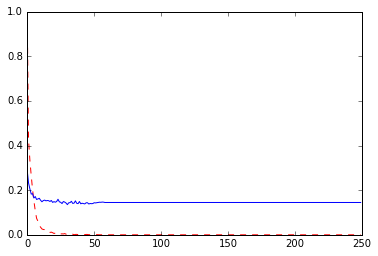

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(tr_cost_no_reg / max(tr_cost_no_reg),'r--')
plt.plot(cv_error_no_reg,'b')
plt.show()

In [11]:
# save to .npz
np.save('no_reg', [tr_cost_no_reg, cv_error_no_reg])